In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/distil_bert/keras/distil_bert_base_en_uncased/1/config.json
/kaggle/input/distil_bert/keras/distil_bert_base_en_uncased/1/tokenizer.json
/kaggle/input/distil_bert/keras/distil_bert_base_en_uncased/1/metadata.json
/kaggle/input/distil_bert/keras/distil_bert_base_en_uncased/1/model.weights.h5
/kaggle/input/distil_bert/keras/distil_bert_base_en_uncased/1/assets/tokenizer/vocabulary.txt
/kaggle/input/nlp-getting-started/sample_submission.csv
/kaggle/input/nlp-getting-started/train.csv
/kaggle/input/nlp-getting-started/test.csv
/kaggle/input/bert/tensorflow2/en-cased-preprocess/3/saved_model.pb
/kaggle/input/bert/tensorflow2/en-cased-preprocess/3/keras_metadata.pb
/kaggle/input/bert/tensorflow2/en-cased-preprocess/3/assets/vocab.txt
/kaggle/input/bert/tensorflow2/en-cased-preprocess/3/variables/variables.index
/kaggle/input/bert/tensorflow2/en-cased-preprocess/3/variables/variables.data-00000-of-00001


# Disaster tweets

0 = Not a disaster
1 = a disaster

In [2]:
import pandas as pd

train_df = pd.read_csv("/kaggle/input/nlp-getting-started/train.csv")
test_df = pd.read_csv('/kaggle/input/nlp-getting-started/test.csv')
train_df

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1


In [3]:
train_df['target'].value_counts()

target
0    4342
1    3271
Name: count, dtype: int64

In [4]:
# check for null data
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [5]:
train_data = train_df["text"]
train_labels = train_df["target"]
train_data

0       Our Deeds are the Reason of this #earthquake M...
1                  Forest fire near La Ronge Sask. Canada
2       All residents asked to 'shelter in place' are ...
3       13,000 people receive #wildfires evacuation or...
4       Just got sent this photo from Ruby #Alaska as ...
                              ...                        
7608    Two giant cranes holding a bridge collapse int...
7609    @aria_ahrary @TheTawniest The out of control w...
7610    M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...
7611    Police investigating after an e-bike collided ...
7612    The Latest: More Homes Razed by Northern Calif...
Name: text, Length: 7613, dtype: object

In [6]:
# split the train_data into train and valid sets 
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(train_data,
                                                     train_labels,
                                                     test_size=0.1,
                                                     random_state=42,
                                                     shuffle=True)
len(X_train), len(y_train), len(X_valid), len(y_valid)

(6851, 6851, 762, 762)

In [7]:
X_train[1], y_train[1]

('Forest fire near La Ronge Sask. Canada', 1)

Prepare the data for Neural Networks

* Vectorization layer will convert text to numbers
* Embedding layers will capture relationships between those numbers

In [8]:
# convert text to numbers
import numpy as np 

tweet_lengths = [len(tweet.split()) for tweet in X_train] # an array of all tweet lengths
avg_tweet_length = np.mean(tweet_lengths)
avg_tweet_length

14.87447088016348

(array([ 355.,  974., 1530., 2081., 1242.,  556.,  113.]),
 array([ 1.        ,  5.28571429,  9.57142857, 13.85714286, 18.14285714,
        22.42857143, 26.71428571, 31.        ]),
 <BarContainer object of 7 artists>)

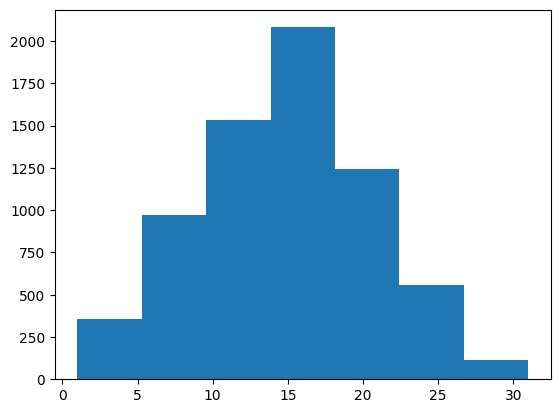

In [9]:
import matplotlib.pyplot as plt
plt.hist(tweet_lengths, bins=7)

Looks like most sentences are between 5 and 25

In [10]:
# how long of a tweet covers 95% of the length?
output_seq_len = int(np.percentile(tweet_lengths, 95))
output_seq_len

24

In [11]:
import tensorflow as tf

max_vocab_length = 10000

text_vectorizer = tf.keras.layers.TextVectorization(max_tokens=max_vocab_length,
                                                   pad_to_max_tokens=True,
                                                   output_sequence_length=24,
                                                   split="whitespace",
                                                   output_mode="int",
                                                   standardize="lower_and_strip_punctuation")

In [12]:
text_vectorizer.adapt(X_train)

In [13]:
import random

target_sentence = random.choice(X_train)
print(f"Text:\n{target_sentence}")
print(f"\nLength of text: {len(target_sentence.split())}")
print(f"\nVectorized text:\n{text_vectorizer([target_sentence])}")

Text:
#News: 'Many deaths' in shipwreck: Rescuers are trying to save hundreds of migrants after the... http://t.co/tX51oYbrN6 via @TheNewsHype

Length of text: 18

Vectorized text:
[[  57  134  331    4 3423  321   21  640    5  338  416    6  341   38
     2    1   51 7606    0    0    0    0    0    0]]


In [14]:
# How many words in our training vocabulary?
tweets_text_vocab = text_vectorizer.get_vocabulary()
print(f"Number of words in vocabulary: {len(tweets_text_vocab)}"),
print(f"Most common words in the vocabulary: {tweets_text_vocab[:5]}")
print(f"Least common words in the vocabulary: {tweets_text_vocab[-5:]}")

Number of words in vocabulary: 10000
Most common words in the vocabulary: ['', '[UNK]', 'the', 'a', 'in']
Least common words in the vocabulary: ['pakthey', 'pakistan\x89Ûªs', 'pakistans', 'pajamas', 'paints']


## Create the token embedding

In [15]:
token_embedding = tf.keras.layers.Embedding(input_dim=len(tweets_text_vocab),
                                           output_dim=128, # size of output embedding vector. Ie: a value of 100 outputs a feature vector of size 100 for each word
                                           mask_zero=True,
                                           name="token_embed")

In [16]:
# Show example embedding
print(f"Sentence before vectorization:\n{target_sentence}\n")
vectorized_sentence = text_vectorizer([target_sentence])
print(f"Sentence after vectorization (before embedding):\n{vectorized_sentence}\n")
embedded_sentence = token_embedding(vectorized_sentence)
print(f"Sentence after embedding:\n{embedded_sentence}\n")
print(f"Embedded sentence shape: {embedded_sentence.shape}")

Sentence before vectorization:
#News: 'Many deaths' in shipwreck: Rescuers are trying to save hundreds of migrants after the... http://t.co/tX51oYbrN6 via @TheNewsHype

Sentence after vectorization (before embedding):
[[  57  134  331    4 3423  321   21  640    5  338  416    6  341   38
     2    1   51 7606    0    0    0    0    0    0]]

Sentence after embedding:
[[[ 0.03019544 -0.02418411  0.01751139 ... -0.01936489 -0.01953087
    0.03324485]
  [-0.00149969  0.04522185  0.04490285 ... -0.04235858  0.00419889
    0.01360964]
  [-0.04690814 -0.02690545 -0.01564493 ...  0.02323444  0.04659337
   -0.04844758]
  ...
  [-0.01573888  0.00268257 -0.0046014  ...  0.02686039  0.04894122
    0.00162994]
  [-0.01573888  0.00268257 -0.0046014  ...  0.02686039  0.04894122
    0.00162994]
  [-0.01573888  0.00268257 -0.0046014  ...  0.02686039  0.04894122
    0.00162994]]]

Embedded sentence shape: (1, 24, 128)


In [17]:
# Get a random sentence from training set
random_sentence = random.choice(X_train)
print(f"Original text:\n{random_sentence}\
      \n\nEmbedded version:")

# Embed the random sentence (turn it into numerical representation)
sample_embed = token_embedding(text_vectorizer([random_sentence]))
sample_embed

Original text:
@random_tourist it rained. Some guys tree hit by lightning and some jackholes drove onto flooded streets.      

Embedded version:


<tf.Tensor: shape=(1, 24, 128), dtype=float32, numpy=
array([[[-0.01000402,  0.02437745,  0.03948537, ..., -0.03636986,
          0.00658759, -0.00348108],
        [-0.03506844,  0.0406344 ,  0.01081747, ..., -0.02909932,
          0.02497986,  0.01631084],
        [ 0.00942886, -0.01196678,  0.01535243, ..., -0.03290317,
          0.02591038, -0.02769855],
        ...,
        [-0.01573888,  0.00268257, -0.0046014 , ...,  0.02686039,
          0.04894122,  0.00162994],
        [-0.01573888,  0.00268257, -0.0046014 , ...,  0.02686039,
          0.04894122,  0.00162994],
        [-0.01573888,  0.00268257, -0.0046014 , ...,  0.02686039,
          0.04894122,  0.00162994]]], dtype=float32)>

In [18]:
# check out a single tokens embedding
sample_embed[0][0]

<tf.Tensor: shape=(128,), dtype=float32, numpy=
array([-1.00040212e-02,  2.43774541e-02,  3.94853689e-02, -2.78397929e-02,
       -4.59815264e-02, -4.17415127e-02,  3.27600501e-02,  4.49448265e-02,
       -1.63150206e-02, -4.95513082e-02,  1.43349878e-02,  1.84648111e-03,
        4.50806059e-02, -1.33390315e-02, -3.85915861e-02,  1.37749650e-02,
       -4.08224352e-02, -4.14562225e-03, -3.50546129e-02, -2.99784895e-02,
       -1.71714053e-02,  3.83880772e-02,  4.02889960e-02,  4.04076651e-03,
       -3.96116152e-02,  9.44361091e-05,  4.15216759e-03,  1.29116215e-02,
        1.43699162e-02,  2.75588892e-02,  1.91606916e-02, -1.96596514e-02,
       -1.00344047e-02,  9.19680670e-03,  2.16869265e-03, -4.29504029e-02,
        1.14498138e-02, -9.33218002e-03, -1.59054026e-02, -3.22229862e-02,
        2.04294212e-02,  3.11428793e-02,  3.95304002e-02, -1.04162842e-03,
        2.77494229e-02, -1.29353181e-02, -3.32513936e-02,  2.41281502e-02,
       -2.54145153e-02,  2.03067064e-03, -1.78489797

Notice its an array of size 128. Each word is represented in an array of 128 values. 

Its a tensorflow layer, which is important b/c it can be used as part of a model. Its parameters(word representations) can be updated and improved as the model learns. 

### Load in datasets faster

In [19]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
valid_dataset = tf.data.Dataset.from_tensor_slices((X_valid, y_valid))

train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
valid_dataset = valid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [20]:
inputs = tf.keras.Input(shape=(1,), dtype="string") # 1 dimensional strings

x = text_vectorizer(inputs) # turn input text into numbers
x = token_embedding(x)

x = tf.keras.layers.GlobalAveragePooling1D()(x)

outputs = tf.keras.layers.Dense(1, activation="sigmoid")(x)

model_1 = tf.keras.Model(inputs, outputs, name="model_1")

In [21]:
model_1.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [22]:
model_1.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVe  (None, 24)                0         
 ctorization)                                                    
                                                                 
 token_embed (Embedding)     (None, 24, 128)           1280000   
                                                                 
 global_average_pooling1d (  (None, 128)               0         
 GlobalAveragePooling1D)                                         
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 1280129 (4.88 MB)
Trainable params: 1280129 (

In [23]:
model_1_history = model_1.fit(train_dataset,
                             epochs=5,
                             validation_data=(valid_dataset))

Epoch 1/5
215/215 [==============================] - 3s 11ms/step - loss: 0.6026 - accuracy: 0.7062 - val_loss: 0.5220 - val_accuracy: 0.7848
Epoch 2/5
215/215 [==============================] - 2s 10ms/step - loss: 0.4202 - accuracy: 0.8313 - val_loss: 0.4793 - val_accuracy: 0.7874
Epoch 3/5
215/215 [==============================] - 2s 11ms/step - loss: 0.3265 - accuracy: 0.8721 - val_loss: 0.4876 - val_accuracy: 0.7900
Epoch 4/5
215/215 [==============================] - 2s 11ms/step - loss: 0.2641 - accuracy: 0.8999 - val_loss: 0.5117 - val_accuracy: 0.7874
Epoch 5/5
215/215 [==============================] - 2s 11ms/step - loss: 0.2170 - accuracy: 0.9225 - val_loss: 0.5446 - val_accuracy: 0.7822


## Model 2: Transfer Learning

In [24]:
import tensorflow_text as text
import tensorflow_hub as hub

In [25]:
sentence_encoder_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        input_shape=[], # shape of inputs coming to our model 
                                        dtype=tf.string, # data type of inputs coming to the USE layer
                                        trainable=False, # keep the pretrained weights (we'll create a feature extractor)
                                        name="USE") 

In [26]:
# Create model using the Sequential API
model_2 = tf.keras.Sequential([
  sentence_encoder_layer, # take in sentences and then encode them into an embedding
  tf.keras.layers.Dense(64, activation="relu"),
  tf.keras.layers.Dense(1, activation="sigmoid")
], name="model_2_USE")

In [27]:
# import tensorflow_hub as hub
# text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
# preprocessing_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3", name='preprocessing')
# encoder_inputs = preprocessing_layer(text_input)
# encoder = hub.KerasLayer("https://tfhub.dev/google/distilbert_base_uncased/1", trainable=False, name='BERT_encoder')
# outputs = encoder(encoder_inputs)
# x = outputs['pooled_output']
# x = tf.keras.layers.Dropout(0.1)(x)
# x = tf.keras.layers.Dense(1, activation=None, name='classifier')(x)
# model_2 = tf.keras.Model(text_input, x, name="model_2")

In [28]:
model_2.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [29]:
model_2.summary()

Model: "model_2_USE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense_1 (Dense)             (None, 64)                32832     
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 256830721 (979.73 MB)
Trainable params: 32897 (128.50 KB)
Non-trainable params: 256797824 (979.61 MB)
_________________________________________________________________


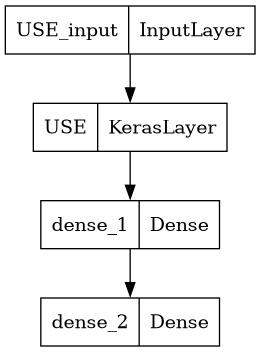

In [30]:
tf.keras.utils.plot_model(model_2)

In [31]:
# early_stopping = tf.keras.callbacks.EarlyStopping(
#     monitor='val_loss',  # Metric to monitor
#     patience=3,  # Number of epochs with no improvement after which training will be stopped
#     verbose=1,  # Logs when training is stopped
#     restore_best_weights=True  # Restores model weights from the epoch with the best value of the monitored quantity
# )
early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                                          patience=5,
                                                          restore_best_weights=True)

In [32]:
model_2_history = model_2.fit(train_dataset,
                             epochs=100,
                             validation_data=(valid_dataset),
                             callbacks=[early_stopping_callback])

Epoch 1/100
215/215 [==============================] - 6s 18ms/step - loss: 0.5112 - accuracy: 0.7714 - val_loss: 0.4233 - val_accuracy: 0.8110
Epoch 2/100
215/215 [==============================] - 3s 14ms/step - loss: 0.4191 - accuracy: 0.8146 - val_loss: 0.4068 - val_accuracy: 0.8189
Epoch 3/100
215/215 [==============================] - 3s 14ms/step - loss: 0.4050 - accuracy: 0.8205 - val_loss: 0.4026 - val_accuracy: 0.8228
Epoch 4/100
215/215 [==============================] - 3s 14ms/step - loss: 0.3958 - accuracy: 0.8259 - val_loss: 0.4008 - val_accuracy: 0.8228
Epoch 5/100
215/215 [==============================] - 3s 14ms/step - loss: 0.3881 - accuracy: 0.8300 - val_loss: 0.4003 - val_accuracy: 0.8268
Epoch 6/100
215/215 [==============================] - 3s 15ms/step - loss: 0.3808 - accuracy: 0.8323 - val_loss: 0.3999 - val_accuracy: 0.8268
Epoch 7/100
215/215 [==============================] - 3s 14ms/step - loss: 0.3738 - accuracy: 0.8361 - val_loss: 0.3999 - val_accuracy:

In [33]:
model_2.evaluate(valid_dataset)

24/24 [==============================] - 0s 8ms/step - loss: 0.3999 - accuracy: 0.8255


[0.399919718503952, 0.8254593014717102]

In [34]:
import tensorflow_hub as hub
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4") # load Universal Sentence Encoder
embed_samples = embed(["When you call the universal sentence encoder on a sentence, it turns it into numbers."])
embed_samples

<tf.Tensor: shape=(1, 512), dtype=float32, numpy=
array([[ 3.59669104e-02, -8.57946873e-02, -1.15274275e-02,
         5.25982305e-03, -1.85217243e-02, -5.04201166e-02,
        -3.61694135e-02,  5.34677319e-03,  4.80591655e-02,
         4.69074361e-02, -3.72333042e-02, -1.14954598e-02,
         4.35241461e-02,  7.05099106e-02,  7.09376037e-02,
        -8.18043128e-02,  8.71716719e-03, -4.65412140e-02,
        -2.24577561e-02,  4.68687192e-02,  2.02255719e-03,
         3.09907217e-02,  2.04356313e-02,  6.39216825e-02,
        -7.64108598e-02,  8.42117891e-02, -4.57604155e-02,
        -1.06165453e-03, -2.05941647e-02,  1.24110589e-02,
         5.72753921e-02,  3.81562002e-02, -2.74211802e-02,
        -3.54347494e-03, -9.83258560e-02, -1.24485437e-02,
         3.86562981e-02,  5.03195338e-02, -2.36250591e-02,
         3.21848248e-03,  3.22520882e-02,  7.38095073e-03,
         4.47310396e-02, -4.12235968e-03,  1.15160132e-02,
         2.83772387e-02,  6.01386302e-04, -5.90335354e-02,
      

In [35]:
# import tensorflow_hub as hub
# embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4") # load Universal Sentence Encoder
# embed_samples = embed([sample_sentence,
#                       "When you call the universal sentence encoder on a sentence, it turns it into numbers."])

# print(embed_samples[0][:50])

# We can use this encoding layer in place of our text_vectorizer and embedding layer
# sentence_encoder_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
#                                         input_shape=[], # shape of inputs coming to our model 
#                                         dtype=tf.string, # data type of inputs coming to the USE layer
#                                         trainable=False, # keep the pretrained weights (we'll create a feature extractor)
#                                         name="USE") 

# Create model using the Sequential API
# model_6 = tf.keras.Sequential([
#   sentence_encoder_layer, # take in sentences and then encode them into an embedding
#   layers.Dense(64, activation="relu"),
#   layers.Dense(1, activation="sigmoid")
# ], name="model_6_USE")

# # Compile model
# model_6.compile(loss="binary_crossentropy",
#                 optimizer=tf.keras.optimizers.Adam(),
#                 metrics=["accuracy"])

# model_6.summary()

# text_input = tf.keras.layers.Input(shape=(), dtype=tf.string)
# preprocessor = hub.KerasLayer(
#     "https://kaggle.com/models/tensorflow/bert/frameworks/TensorFlow2/variations/en-uncased-preprocess/versions/3")
# encoder_inputs = preprocessor(text_input)
# encoder = hub.KerasLayer(
#     "https://www.kaggle.com/models/tensorflow/bert/frameworks/TensorFlow2/variations/bert-en-uncased-l-10-h-128-a-2/versions/2",
#     trainable=True)
# outputs = encoder(encoder_inputs)
# pooled_output = outputs["pooled_output"]      # [batch_size, 128].
# sequence_output = outputs["sequence_output"]  # [batch_size, seq_length, 128].



In [36]:
# # Code below is adapted from: https://www.tensorflow.org/tutorials/text/word_embeddings#retrieve_the_trained_word_embeddings_and_save_them_to_disk
# import io

# # Create output writers
# out_v = io.open("embedding_vectors.tsv", "w", encoding="utf-8")
# out_m = io.open("embedding_metadata.tsv", "w", encoding="utf-8")

# # Write embedding vectors and words to file
# for num, word in enumerate(words_in_vocab):
#   if num == 0: 
#      continue # skip padding token
#   vec = embed_weights[num]
#   out_m.write(word + "\n") # write words to file
#   out_v.write("\t".join([str(x) for x in vec]) + "\n") # write corresponding word vector to file
# out_v.close()
# out_m.close()

# # Download files locally to upload to Embedding Projector
# try:
#   from google.colab import files
# except ImportError:
#   pass
# else:
#   files.download("embedding_vectors.tsv")
#   files.download("embedding_metadata.tsv")

## Model 3: LSTM 

In [37]:
inputs = tf.keras.layers.Input(shape=(), dtype="string")
x = text_vectorizer(inputs)
x = token_embedding(x)
x = tf.keras.layers.LSTM(64)(x)
outputs = tf.keras.layers.Dense(1, activation="sigmoid")(x)

model_3 = tf.keras.Model(inputs, outputs, name="model_3_lstm")

# inputs = tf.keras.Input(shape=(1,), dtype="string") # 1 dimensional strings

# x = text_vectorizer(inputs) # turn input text into numbers
# x = token_embedding(x)

# x = tf.keras.layers.GlobalAveragePooling1D()(x)

# outputs = tf.keras.layers.Dense(1, activation="sigmoid")(x)

# model_1 = tf.keras.Model(inputs, outputs, name="model_1")

In [38]:
model_3.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [39]:
model_3.summary()

Model: "model_3_lstm"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None,)]                 0         
                                                                 
 text_vectorization (TextVe  (None, 24)                0         
 ctorization)                                                    
                                                                 
 token_embed (Embedding)     (None, 24, 128)           1280000   
                                                                 
 lstm (LSTM)                 (None, 64)                49408     
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 1329473 (5.07 MB)
Trainable params: 1329473 (5.07 MB)
Non-trainable params: 0 (0.00 Byte)
________________

In [40]:
model_3_history = model_3.fit(train_dataset,
                             epochs=100,
                             validation_data=(valid_dataset),
                             callbacks=[early_stopping_callback])

Epoch 1/100
215/215 [==============================] - 10s 29ms/step - loss: 0.2038 - accuracy: 0.9355 - val_loss: 0.6440 - val_accuracy: 0.7533
Epoch 2/100
215/215 [==============================] - 5s 24ms/step - loss: 0.1408 - accuracy: 0.9479 - val_loss: 0.7683 - val_accuracy: 0.7598
Epoch 3/100
215/215 [==============================] - 5s 23ms/step - loss: 0.1099 - accuracy: 0.9588 - val_loss: 0.9327 - val_accuracy: 0.7546
Epoch 4/100
215/215 [==============================] - 5s 23ms/step - loss: 0.0874 - accuracy: 0.9664 - val_loss: 1.0929 - val_accuracy: 0.7415
Epoch 5/100
215/215 [==============================] - 5s 25ms/step - loss: 0.0734 - accuracy: 0.9711 - val_loss: 1.1178 - val_accuracy: 0.7402
Epoch 6/100
215/215 [==============================] - 5s 25ms/step - loss: 0.0657 - accuracy: 0.9720 - val_loss: 1.0928 - val_accuracy: 0.7454


In [41]:
model_3.evaluate(valid_dataset)

24/24 [==============================] - 0s 7ms/step - loss: 0.6440 - accuracy: 0.7533


[0.6439670324325562, 0.7532808184623718]

In [42]:
model_2.evaluate(valid_dataset)

24/24 [==============================] - 0s 8ms/step - loss: 0.3999 - accuracy: 0.8255


[0.399919718503952, 0.8254593014717102]

In [43]:
model_1.evaluate(valid_dataset)

24/24 [==============================] - 0s 3ms/step - loss: 0.5557 - accuracy: 0.7651


[0.5556552410125732, 0.7650918364524841]

## Model 4: GRU

In [44]:
inputs = tf.keras.layers.Input(shape=(), dtype="string")
x = text_vectorizer(inputs)
x = token_embedding(x)
x = tf.keras.layers.GRU(64)(x)
outputs = tf.keras.layers.Dense(1, activation="sigmoid")(x)

model_4 = tf.keras.Model(inputs, outputs, name="model_4_gru")

In [45]:
model_4.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [46]:
model_4.summary()

Model: "model_4_gru"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None,)]                 0         
                                                                 
 text_vectorization (TextVe  (None, 24)                0         
 ctorization)                                                    
                                                                 
 token_embed (Embedding)     (None, 24, 128)           1280000   
                                                                 
 gru (GRU)                   (None, 64)                37248     
                                                                 
 dense_4 (Dense)             (None, 1)                 65        
                                                                 
Total params: 1317313 (5.03 MB)
Trainable params: 1317313 (5.03 MB)
Non-trainable params: 0 (0.00 Byte)
_________________

In [47]:
model_4_history = model_4.fit(train_dataset,
                             epochs=100,
                             validation_data=(valid_dataset),
                             callbacks=[early_stopping_callback])

Epoch 1/100
215/215 [==============================] - 10s 28ms/step - loss: 0.1958 - accuracy: 0.9307 - val_loss: 0.7300 - val_accuracy: 0.7559
Epoch 2/100
215/215 [==============================] - 5s 22ms/step - loss: 0.1275 - accuracy: 0.9555 - val_loss: 0.8393 - val_accuracy: 0.7454
Epoch 3/100
215/215 [==============================] - 5s 22ms/step - loss: 0.1036 - accuracy: 0.9642 - val_loss: 0.9693 - val_accuracy: 0.7362
Epoch 4/100
215/215 [==============================] - 5s 22ms/step - loss: 0.0871 - accuracy: 0.9695 - val_loss: 1.0267 - val_accuracy: 0.7323
Epoch 5/100
215/215 [==============================] - 5s 22ms/step - loss: 0.0775 - accuracy: 0.9724 - val_loss: 1.0742 - val_accuracy: 0.7388
Epoch 6/100
215/215 [==============================] - 5s 22ms/step - loss: 0.0685 - accuracy: 0.9743 - val_loss: 1.0965 - val_accuracy: 0.7454


In [48]:
model_4.evaluate(valid_dataset)

24/24 [==============================] - 0s 6ms/step - loss: 0.7300 - accuracy: 0.7559


[0.7300063967704773, 0.7559055089950562]

## Model 5: LSTM and GRU

In [49]:
inputs = tf.keras.layers.Input(shape=(), dtype="string")
x = text_vectorizer(inputs)
x = token_embedding(x)
x = tf.keras.layers.LSTM(64, return_sequences=True)(x)
x = tf.keras.layers.GRU(64)(x)
outputs = tf.keras.layers.Dense(1, activation="sigmoid")(x)

model_5 = tf.keras.Model(inputs, outputs, name="model_5_lstm_and_gru")

In [50]:
model_5.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [51]:
model_5_history = model_5.fit(train_dataset,
                             epochs=100,
                             validation_data=(valid_dataset),
                             callbacks=[early_stopping_callback])

Epoch 1/100
215/215 [==============================] - 18s 48ms/step - loss: 0.1599 - accuracy: 0.9477 - val_loss: 0.7985 - val_accuracy: 0.7559
Epoch 2/100
215/215 [==============================] - 8s 36ms/step - loss: 0.1170 - accuracy: 0.9594 - val_loss: 0.9330 - val_accuracy: 0.7467
Epoch 3/100
215/215 [==============================] - 8s 36ms/step - loss: 0.0956 - accuracy: 0.9653 - val_loss: 1.0365 - val_accuracy: 0.7375
Epoch 4/100
215/215 [==============================] - 8s 36ms/step - loss: 0.0774 - accuracy: 0.9710 - val_loss: 1.1701 - val_accuracy: 0.7270
Epoch 5/100
215/215 [==============================] - 8s 35ms/step - loss: 0.0694 - accuracy: 0.9720 - val_loss: 1.3131 - val_accuracy: 0.7310
Epoch 6/100
215/215 [==============================] - 8s 36ms/step - loss: 0.0614 - accuracy: 0.9739 - val_loss: 1.4176 - val_accuracy: 0.7402


In [52]:
model_5.evaluate(valid_dataset)

24/24 [==============================] - 0s 10ms/step - loss: 0.7985 - accuracy: 0.7559


[0.7984885573387146, 0.7559055089950562]

## Model 6: LSTM and GRU multiple layers

In [53]:
inputs = tf.keras.layers.Input(shape=(), dtype="string")
x = text_vectorizer(inputs)
x = token_embedding(x)
x = tf.keras.layers.LSTM(64, return_sequences=True)(x)
x = tf.keras.layers.GRU(32, return_sequences=True)(x)
x = tf.keras.layers.GRU(16, return_sequences=True)(x)
x = tf.keras.layers.LSTM(8)(x)
outputs = tf.keras.layers.Dense(1, activation="sigmoid")(x)

model_6 = tf.keras.Model(inputs, outputs, name="model_6_mix_rnn")

In [54]:
model_6.summary()

Model: "model_6_mix_rnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None,)]                 0         
                                                                 
 text_vectorization (TextVe  (None, 24)                0         
 ctorization)                                                    
                                                                 
 token_embed (Embedding)     (None, 24, 128)           1280000   
                                                                 
 lstm_2 (LSTM)               (None, 24, 64)            49408     
                                                                 
 gru_2 (GRU)                 (None, 24, 32)            9408      
                                                                 
 gru_3 (GRU)                 (None, 24, 16)            2400      
                                                   

In [55]:
model_6.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])
model_6_history = model_6.fit(train_dataset,
                             epochs=100,
                             validation_data=(valid_dataset),
                             callbacks=[early_stopping_callback])

Epoch 1/100
215/215 [==============================] - 30s 79ms/step - loss: 0.2317 - accuracy: 0.9372 - val_loss: 0.6676 - val_accuracy: 0.7533
Epoch 2/100
215/215 [==============================] - 12s 57ms/step - loss: 0.1342 - accuracy: 0.9588 - val_loss: 0.7385 - val_accuracy: 0.7520
Epoch 3/100
215/215 [==============================] - 12s 57ms/step - loss: 0.1122 - accuracy: 0.9664 - val_loss: 0.8285 - val_accuracy: 0.7454
Epoch 4/100
215/215 [==============================] - 12s 57ms/step - loss: 0.0893 - accuracy: 0.9721 - val_loss: 0.9407 - val_accuracy: 0.7349
Epoch 5/100
215/215 [==============================] - 12s 56ms/step - loss: 0.0751 - accuracy: 0.9756 - val_loss: 0.9715 - val_accuracy: 0.7336
Epoch 6/100
215/215 [==============================] - 12s 58ms/step - loss: 0.0639 - accuracy: 0.9759 - val_loss: 1.0080 - val_accuracy: 0.7415


## Model 7: Bidirectional

* a normal RNN will process a sequence from left to right, where a bidirectional RNN will process the sequence from left to right and then right to left. 
* Many models see improvement in performance when using bidirectional RNNs

In [56]:
tf.random.set_seed(42)
from tensorflow.keras import layers
# model_4_embedding = layers.Embedding(input_dim=max_vocab_length,
#                                      output_dim=128,
#                                      embeddings_initializer="uniform",
#                                      input_length=max_length,
#                                      name="embedding_4")

# Build a Bidirectional RNN in TensorFlow
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = token_embedding(x)
# x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x) # stacking RNN layers requires return_sequences=True
x = layers.Bidirectional(layers.LSTM(64))(x) # bidirectional goes both ways so has double the parameters of a regular LSTM layer
outputs = layers.Dense(1, activation="sigmoid")(x)
model_7 = tf.keras.Model(inputs, outputs, name="model_7_Bidirectional")


In [57]:
model_7.summary()

Model: "model_7_Bidirectional"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVe  (None, 24)                0         
 ctorization)                                                    
                                                                 
 token_embed (Embedding)     (None, 24, 128)           1280000   
                                                                 
 bidirectional (Bidirection  (None, 128)               98816     
 al)                                                             
                                                                 
 dense_7 (Dense)             (None, 1)                 129       
                                                                 
Total params: 1378945 (5.26 MB)
Trainable par

In [58]:
model_7.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])
model_7_history = model_7.fit(train_dataset,
                             epochs=100,
                             validation_data=(valid_dataset),
                             callbacks=[early_stopping_callback])

Epoch 1/100
215/215 [==============================] - 15s 38ms/step - loss: 0.1496 - accuracy: 0.9549 - val_loss: 0.7673 - val_accuracy: 0.7546
Epoch 2/100
215/215 [==============================] - 6s 28ms/step - loss: 0.1101 - accuracy: 0.9632 - val_loss: 0.8662 - val_accuracy: 0.7507
Epoch 3/100
215/215 [==============================] - 6s 28ms/step - loss: 0.0915 - accuracy: 0.9680 - val_loss: 0.9441 - val_accuracy: 0.7454
Epoch 4/100
215/215 [==============================] - 6s 28ms/step - loss: 0.0785 - accuracy: 0.9705 - val_loss: 1.0356 - val_accuracy: 0.7323
Epoch 5/100
215/215 [==============================] - 6s 27ms/step - loss: 0.0679 - accuracy: 0.9739 - val_loss: 1.0582 - val_accuracy: 0.7087
Epoch 6/100
215/215 [==============================] - 6s 28ms/step - loss: 0.0582 - accuracy: 0.9761 - val_loss: 1.6568 - val_accuracy: 0.6995


## Model 8: Conv1D

In [59]:
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = token_embedding(x)
x = layers.Conv1D(filters=32, kernel_size=5, activation="relu")(x)
x = layers.GlobalMaxPool1D()(x)
# x = layers.Dense(64, activation="relu")(x) # optional dense layer
outputs = layers.Dense(1, activation="sigmoid")(x)
model_8 = tf.keras.Model(inputs, outputs, name="model_8_Conv1D")

In [60]:
model_8.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])
model_8_history = model_8.fit(train_dataset,
                             epochs=100,
                             validation_data=(valid_dataset),
                             callbacks=[early_stopping_callback])

Epoch 1/100
215/215 [==============================] - 3s 13ms/step - loss: 0.1635 - accuracy: 0.9472 - val_loss: 0.8631 - val_accuracy: 0.7402
Epoch 2/100
215/215 [==============================] - 3s 12ms/step - loss: 0.1132 - accuracy: 0.9597 - val_loss: 0.9698 - val_accuracy: 0.7428
Epoch 3/100
215/215 [==============================] - 2s 11ms/step - loss: 0.0885 - accuracy: 0.9645 - val_loss: 1.0629 - val_accuracy: 0.7415
Epoch 4/100
215/215 [==============================] - 2s 12ms/step - loss: 0.0724 - accuracy: 0.9708 - val_loss: 1.1489 - val_accuracy: 0.7415
Epoch 5/100
215/215 [==============================] - 3s 12ms/step - loss: 0.0628 - accuracy: 0.9730 - val_loss: 1.2154 - val_accuracy: 0.7336
Epoch 6/100
215/215 [==============================] - 3s 12ms/step - loss: 0.0565 - accuracy: 0.9749 - val_loss: 1.2521 - val_accuracy: 0.7402


In [61]:
 i = model_8.evaluate(valid_dataset)

24/24 [==============================] - 0s 4ms/step - loss: 0.8631 - accuracy: 0.7402


In [62]:
def plot_models(models, val_data=valid_dataset):
    accuracies = []
    names = []
    for m in models:
        _, accuracy = m.evaluate(val_data)
        accuracies.append(accuracy)
        names.append(m.name)
    
    # Plotting the accuracies
    plt.figure()
    plt.bar(names, accuracies, color='skyblue')
    plt.xlabel('Models')
    plt.ylabel('Accuracy')
    plt.title('Model Accuracies')
    plt.xticks(rotation=45, fontsize=8)
    plt.ylim([min(accuracies) - 0.05, max(accuracies) + 0.05])  # Adjust y-axis limits for better visualization
    plt.show()

24/24 [==============================] - 0s 4ms/step - loss: 0.8631 - accuracy: 0.7402


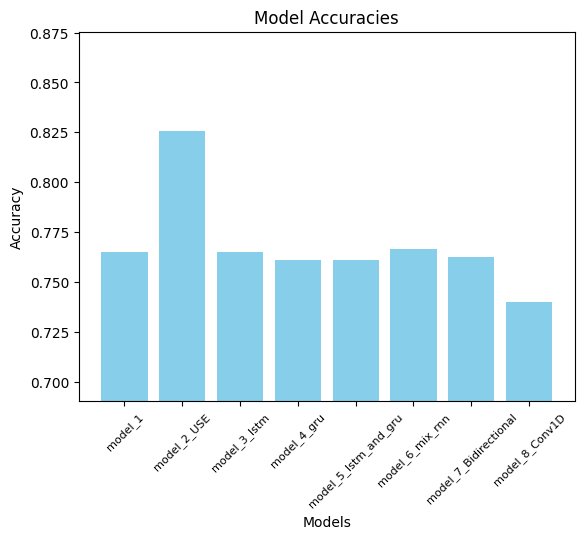

In [63]:
plot_models([model_1, model_2, model_3, model_4, model_5, model_6, model_7, model_8])

## Model Ensembling

* if several uncorrelated models agree on a prediction, then the prediction must be more robust than a prediction made by a single model
* The models should be uncorrelated...different types of models. 
* Ie: using lstm, bidirectional and tensorflow USE model. All these models are trained on the same training data, but they have different ways of finding patterns
* If we were to use 3 similarly trained models such as 3 LSTM models, the predictions they output will be similar. 
* **Averaging Ensemble** - take the output prediction probabilities of each model for each sample. Combine them then average them. 

In [64]:
# use the results from model_1, model_2, model_7 
model_1_preds = model_1.predict(valid_dataset)
model_2_preds = model_2.predict(valid_dataset)
model_7_preds = model_7.predict(valid_dataset)

24/24 [==============================] - 2s 8ms/step


In [65]:
model_7_preds.shape

(762, 1)

In [66]:
# Get mean pred probs for 3 models
combined_pred_probs = tf.squeeze(model_1_preds, axis=1) + tf.squeeze(model_2_preds, axis=1) + tf.squeeze(model_7_preds, axis=1)
combined_preds = tf.round(combined_pred_probs/3)
combined_preds

<tf.Tensor: shape=(762,), dtype=float32, numpy=
array([0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 1.,
       0., 1., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 0., 1., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 1., 0., 1., 1., 0.,
       1., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0., 1., 0., 0., 1., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0.,
       0., 1., 0., 1., 0., 1., 1., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 1., 1., 1., 1., 0., 1., 0., 1., 0.,
       0., 1., 1., 0., 1., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 1., 0., 0., 1., 1., 1., 0., 1., 1., 1., 0., 1., 0., 1.,
       1., 1., 0., 0., 1., 1., 0., 0., 0., 1., 1., 0., 1., 0., 0., 1., 0.,
       0., 1., 0., 0., 0., 0., 0., 1., 1., 1., 1., 0., 0., 0., 1., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 1., 0., 1., 1., 1., 1., 0., 0

In [67]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def calculate_results(y_true, y_pred):
  """
  Calculates model accuracy, precision, recall and f1 score of a binary classification model.

  Args:
  -----
  y_true = true labels in the form of a 1D array
  y_pred = predicted labels in the form of a 1D array

  Returns a dictionary of accuracy, precision, recall, f1-score.
  """
  # Calculate model accuracy
  model_accuracy = accuracy_score(y_true, y_pred) * 100
  # Calculate model precision, recall and f1 score using "weighted" average
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
  model_results = {"accuracy": model_accuracy,
                  "precision": model_precision,
                  "recall": model_recall,
                  "f1": model_f1}
  return model_results

In [68]:
ensemble_results = calculate_results(y_valid, combined_preds)
ensemble_results

{'accuracy': 79.00262467191601,
 'precision': 0.7895463977631777,
 'recall': 0.7900262467191601,
 'f1': 0.7891155349992447}

In [69]:
model_7_results = calculate_results(y_valid, tf.squeeze(tf.round(model_7_preds), axis=1))
model_7_results

{'accuracy': 76.24671916010499,
 'precision': 0.7623943018867197,
 'recall': 0.7624671916010499,
 'f1': 0.762429426257091}

## Try submission

In [70]:
model_7.predict(["There is a tornado in my area"])

1/1 [==============================] - 3s 3s/step


array([[0.98391265]], dtype=float32)

In [71]:
test_text_df = test_df["text"]
test_text_df

0                      Just happened a terrible car crash
1       Heard about #earthquake is different cities, s...
2       there is a forest fire at spot pond, geese are...
3                Apocalypse lighting. #Spokane #wildfires
4           Typhoon Soudelor kills 28 in China and Taiwan
                              ...                        
3258    EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...
3259    Storm in RI worse than last hurricane. My city...
3260    Green Line derailment in Chicago http://t.co/U...
3261    MEG issues Hazardous Weather Outlook (HWO) htt...
3262    #CityofCalgary has activated its Municipal Eme...
Name: text, Length: 3263, dtype: object

In [72]:
# use the results from model_1, model_2, model_7 
model_1_preds_test = model_1.predict(test_text_df)
model_2_preds_test = model_2.predict(test_text_df)
model_3_preds_test = model_3.predict(test_text_df)

102/102 [==============================] - 2s 7ms/step


In [73]:
# Get mean pred probs for 3 models
combined_pred_probs = tf.squeeze(model_1_preds_test, axis=1) + tf.squeeze(model_2_preds_test, axis=1) + tf.squeeze(model_3_preds_test, axis=1)
combined_preds = tf.round(combined_pred_probs/3)
combined_preds

<tf.Tensor: shape=(3263,), dtype=float32, numpy=array([1., 0., 1., ..., 1., 1., 1.], dtype=float32)>

In [74]:
submission_df = pd.DataFrame({
    "id": test_df["id"],
    "target": combined_preds
})

In [75]:
submission_df

,id,target
0,0,1.0
1,2,0.0
2,3,1.0
3,9,1.0
4,11,1.0
...,...,...
3258,10861,1.0
3259,10865,1.0
3260,10868,1.0
3261,10874,1.0


In [76]:
submission_df.to_csv('submission.csv', index=False)